In [4]:
from importlib import reload
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import pmdarima
import darts
from statsmodels.graphics.tsaplots import plot_acf

# Silencing Pandas warnings
import warnings
warnings.filterwarnings("ignore", message="Could not infer format")
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.set_option('max_colwidth', 400)

In [5]:
from scripts.data_extraction import get_all_lobbying_data, lobbying_totals

lobbying_train = get_all_lobbying_data()

all_totals = lobbying_train.groupby("period_start")[["income", "expenses"]].sum()
all_totals["total"] = all_totals.sum(axis=1)

codes = [x.stem[-3:] for x in Path("lobbying_data/by_issue_code/").glob("*.csv")]
for code in codes:
    code_totals = lobbying_totals(code, adjust_for_num_codes=True)
    code_totals.columns = [f"{code}_income", f"{code}_expenses", f"{code}_total"]
    all_totals = pd.merge(all_totals, code_totals, left_index=True, right_index=True)


In [11]:
foo_ts = darts.TimeSeries.from_series(all_totals["FOO_total"])
foo_ts

<TimeSeries (DataArray) (period_start: 40, component: 1, sample: 1)> Size: 320B
array([[[5789449.81127298]],

       [[6588138.75686181]],

       [[6756576.98152471]],

       [[7292687.72033622]],

       [[6733636.0084595 ]],

       [[7159565.5445746 ]],

       [[7945948.5940879 ]],

       [[7609781.22814076]],

       [[7895263.71724137]],

       [[8112206.95889772]],

...

       [[5118392.29827228]],

       [[5510014.53150068]],

       [[5449602.29282852]],

       [[5424227.95846018]],

       [[5226096.04708174]],

       [[5581820.65363297]],

       [[5994294.66855659]],

       [[6351214.81812518]],

       [[6670013.2682646 ]],

       [[6439525.61489612]]])
Coordinates:
  * period_start  (period_start) datetime64[ns] 320B 2013-01-01 ... 2022-10-01
  * component     (component) object 8B 'FOO_total'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

<Axes: xlabel='period_start'>

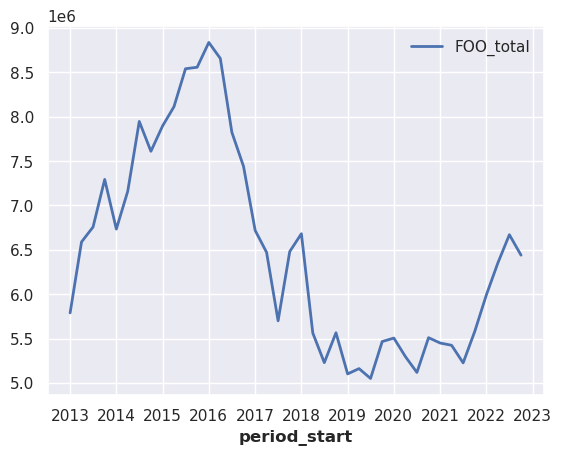

In [13]:
foo_ts.plot()

<Axes: xlabel='period_start'>

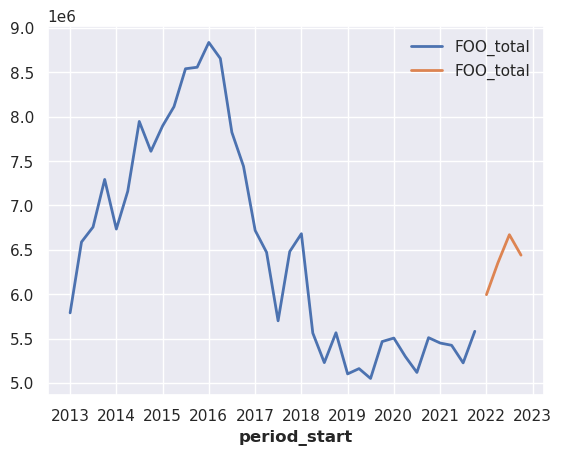

In [16]:
foo_train, foo_val = foo_ts[:-4], foo_ts[-4:]
foo_train.plot()
foo_val.plot()

<Axes: xlabel='period_start'>

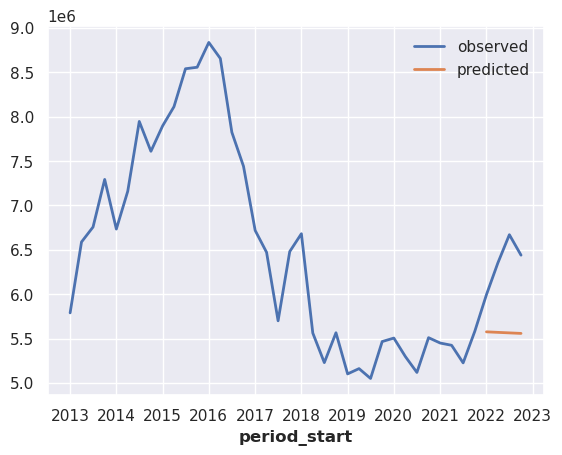

In [18]:
from darts.models import NaiveDrift

model = NaiveDrift().fit(foo_train)
y_pred = model.predict(4)

foo_ts.plot(label="observed")
y_pred.plot(label="predicted")

<Axes: xlabel='period_start'>

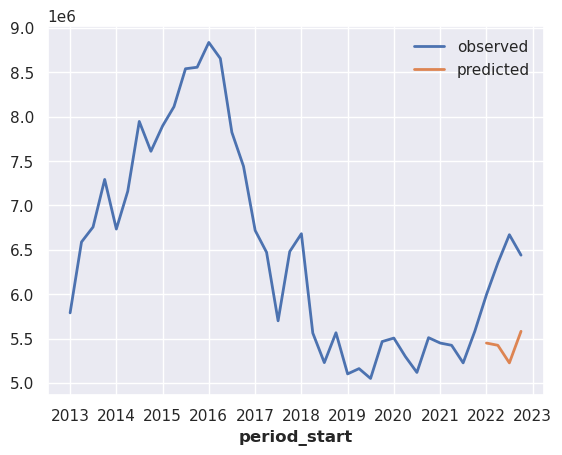

In [21]:
from darts.models import NaiveSeasonal

model = NaiveSeasonal(K=4).fit(foo_train)
y_pred = model.predict(4)

foo_ts.plot(label="observed")
y_pred.plot(label="predicted")

In [79]:
import matplotlib.lines as mlines
from sklearn.model_selection import TimeSeriesSplit
from darts import TimeSeries
from darts.metrics import msse
    
def cross_validate(model, col, plot=True):
    test_size = 4
    kf = TimeSeriesSplit(5, test_size=test_size)
    SSSE = 0
    
    if plot:
        fig, ax = plt.subplots()
        sns.lineplot(col, ax=ax)
        forecast_line = mlines.Line2D([], [], color="gray", linestyle="dashed")
        true_line = mlines.Line2D([], [], color="gray", linestyle="solid")

    for train_idx, valid_idx in kf.split(all_totals):
        col_train = TimeSeries.from_series(col.iloc[train_idx])
        col_valid = TimeSeries.from_series(col.iloc[valid_idx])

        model.fit(col_train)
        y_pred = model.predict(4)
        SSSE += msse(col_valid, y_pred, col_train, m=4)

        if plot:
            y_pred.plot(linestyle="dashed", ax=ax)
            
    MSSE = SSSE / kf.get_n_splits()
    
    if plot:
        ax.legend(labels = ["observed", "forecast"], handles=[true_line, forecast_line])
        ax.set_title(col.name + ": MSSE {:0.3f}".format(MSSE))
        
    return MSSE

0.39968697999513003

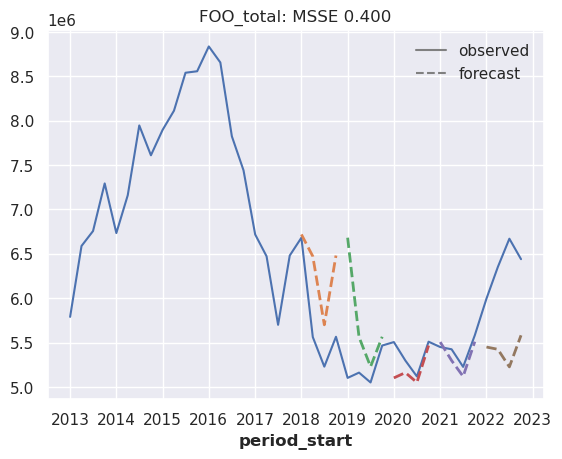

In [80]:
warnings.filterwarnings(action="ignore", message="No artists with labels found.*")
cross_validate(model, all_totals["FOO_total"])

<Axes: xlabel='period_start', ylabel='FOO_income'>

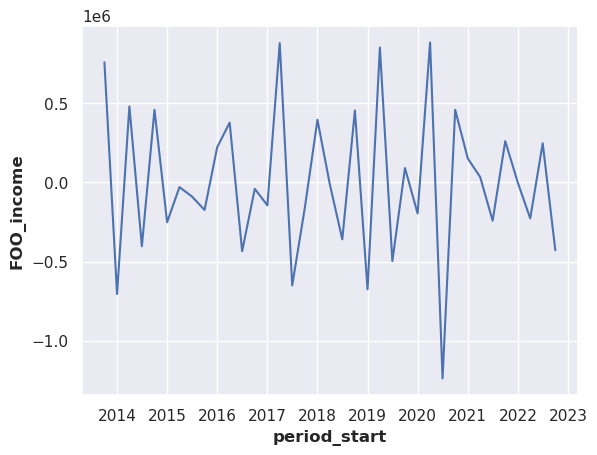

In [86]:
sns.lineplot(all_totals["FOO_income"].diff().diff().diff())

In [97]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
adf_test(all_totals["DEF_expenses"].diff().iloc[1:])

ADF Statistics: -9.974620
p-value: 0.000000
Critical values:
	1%: -3.616
	5%: -2.941
	10%: -2.609
